# Examen Pratique Fil Rouge – Deep Learning IA2

In [2]:

import urllib.request, zipfile, os
url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
zip_path = "caltech101.zip"
urllib.request.urlretrieve(url, zip_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data_caltech101/")
print("Dataset ready in ./data_caltech101/")


Dataset ready in ./data_caltech101/


## 1.2 – Structure du dataset

Dans cette section, on explore l’arborescence du dossier extrait, on compte le nombre
de classes, et on affiche quelques exemples de classes.


In [8]:
import os

base = "data_caltech101"
os.makedirs(base, exist_ok=True)

# cherche tous les dossiers nommés 101_ObjectCategories (ou variantes) sous base
candidates = []
for root, dirs, files in os.walk(base):
    for d in dirs:
        name = d.lower()
        if "101_objectcategories" in name or "101-objectcategories" in name or name.startswith("101_object"):
            candidates.append(os.path.join(root, d))

if not candidates:
    print("Aucun dossier '101_ObjectCategories' trouvé sous", base)
    print("Contenu de", base, ":", os.listdir(base) if os.path.exists(base) else "n'existe pas")
    data_dir = None
    classes = []
else:
    # choisis le candidat ayant le plus de sous-dossiers (probablement le bon niveau contenant les classes)
    def n_subdirs(path):
        try:
            return sum(1 for x in os.listdir(path) if os.path.isdir(os.path.join(path, x)))
        except Exception:
            return 0
    best = max(candidates, key=n_subdirs)
    # si le meilleur contient à son tour un dossier du même nom, descendre d'un niveau
    nested_same = os.path.join(best, os.path.basename(best))
    if os.path.isdir(nested_same) and n_subdirs(nested_same) > n_subdirs(best):
        best = nested_same

    data_dir = best
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    print("Dossier utilisé :", data_dir)
    print("Nombre total de classes :", len(classes))
    print("Exemples de classes :", classes[:10])


Dossier utilisé : data_caltech101\caltech-101\101_ObjectCategories\101_ObjectCategories
Nombre total de classes : 102
Exemples de classes : ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel']


## 1.4 – Visualisation d'images

Affichage de quelques images choisies aléatoirement dans plusieurs classes.
Objectif : observer la variabilité visuelle (taille, contraste, position, etc.)


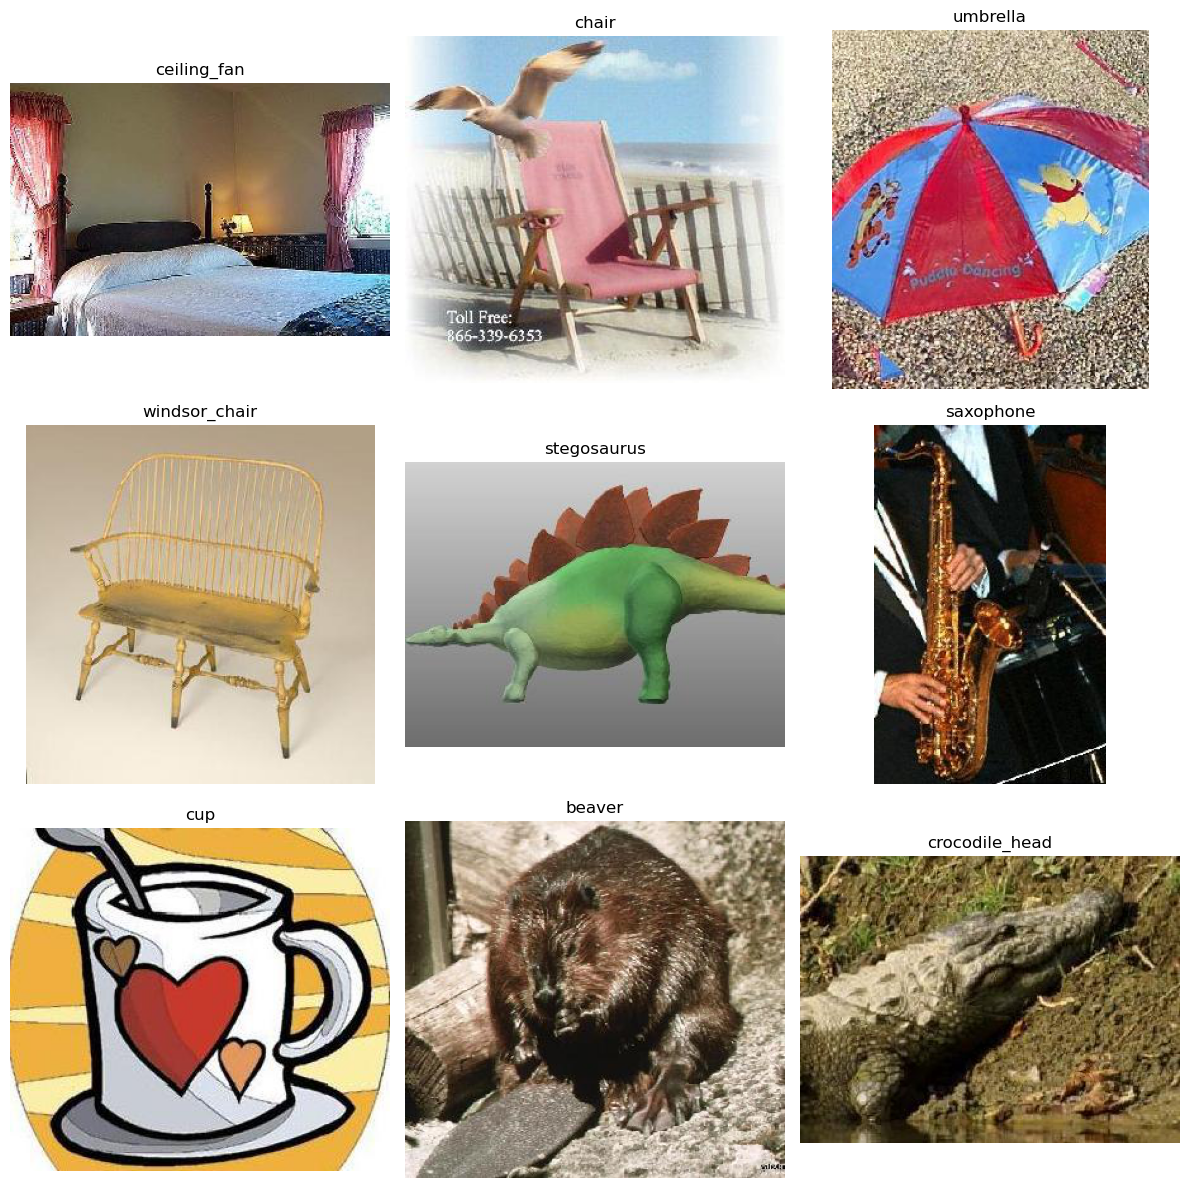

In [10]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# vérifie que data_dir et classes existent
if 'data_dir' not in globals() or data_dir is None or not classes:
    print("Erreur : 'data_dir' ou 'classes' non définis. Exécutez la cellule qui prépare le dataset.")
else:
    plt.figure(figsize=(12,12))
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    count = 0
    attempts = 0
    # on essaie de récupérer jusqu'à 9 images valides (max 100 tentatives pour éviter boucle infinie)
    while count < 9 and attempts < 100:
        attempts += 1
        cls = random.choice(classes)
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_ext)]
        if not imgs:
            continue
        img_name = random.choice(imgs)
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception:
            continue
        plt.subplot(3,3,count+1)
        plt.imshow(np.asarray(img))
        plt.title(cls)
        plt.axis("off")
        img.close()
        count += 1

    if count == 0:
        print("Aucune image valide trouvée dans les classes. Vérifie le contenu de", data_dir)
    plt.tight_layout()
    plt.show()

## 2.1 – Choix de la résolution d'entrée

Nous redimensionnons toutes les images à une résolution choisie (ex : 128×128).
Justification : compromis entre coût de calcul et préservation des détails.


In [11]:
IMG_SIZE = 128


## 2.2 – Normalisation

Nous normalisons les pixels dans [0,1] pour stabiliser l’entraînement.


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


## 2.3 – Train/Validation/Test split

Nous utilisons un split 80% / 20%, stratifié via ImageDataGenerator (par classes).


In [13]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)


Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


## 3.1 – Modèle MLP baseline

Nous construisons un MLP simple après flatten.


In [14]:
from tensorflow.keras import models, layers

model_mlp = models.Sequential([
    layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model_mlp.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_mlp.summary()


c:\Users\thoma\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,218,662 (96.20 MB)

 Trainable params: 25,218,662 (96.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 – Entraînement et courbes

In [15]:
history_mlp = model_mlp.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


c:\Users\thoma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 158s 681ms/step - accuracy: 0.1338 - loss: 10.4209 - val_accuracy: 0.1862 - val_loss: 4.0770
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 61s 265ms/step - accuracy: 0.2015 - loss: 3.7779 - val_accuracy: 0.1745 - val_loss: 3.7440
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 63s 273ms/step - accuracy: 0.2208 - loss: 3.6184 - val_accuracy: 0.2081 - val_loss: 3.6065
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 267ms/step - accuracy: 0.2484 - loss: 3.5077 - val_accuracy: 0.2170 - val_loss: 3.5684
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - accuracy: 0.2538 - loss: 3.4264 - val_accuracy: 0.2315 - val_loss: 3.5114
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 60s 262ms/step - accuracy: 0.2660 - loss: 3.3904 - val_accuracy: 0.2500 - val_loss: 3.4957
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 61s 264ms/step - accuracy: 0.2747 - loss: 3.3424 - val_accuracy: 0.2673 - val_loss: 3.4809
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 258ms/step - accuracy: 0.2811 - loss:

## Courbes d'entraînement du MLP

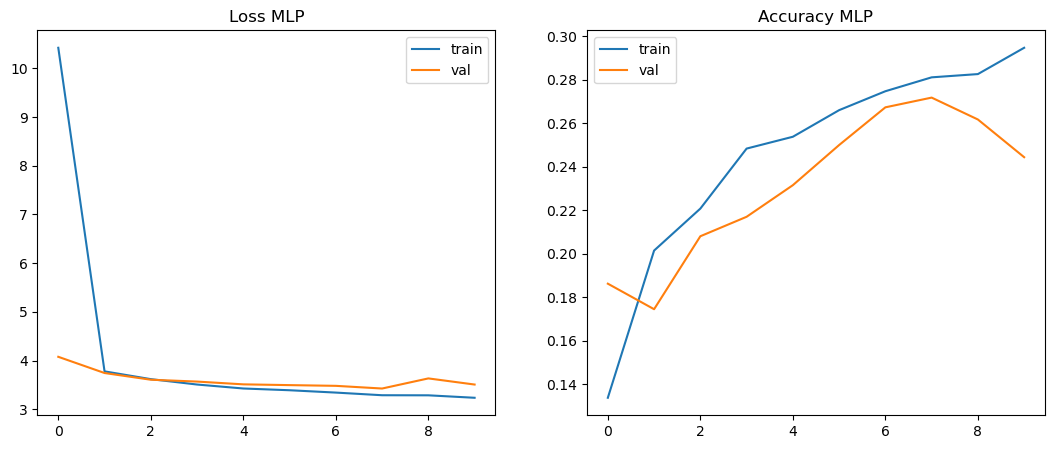

In [16]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(history_mlp.history['loss'], label="train")
plt.plot(history_mlp.history['val_loss'], label="val")
plt.legend()
plt.title("Loss MLP")

plt.subplot(1,2,2)
plt.plot(history_mlp.history['accuracy'], label="train")
plt.plot(history_mlp.history['val_accuracy'], label="val")
plt.legend()
plt.title("Accuracy MLP")

plt.show()


## 4.1 – CNN simple

Architecture CNN classique : Conv → Pool → Conv → Pool → Dense.


In [17]:
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()


c:\Users\thoma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │        13,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,405,478 (28.25 MB)

 Trainable params: 7,405,478 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 – Entraînement du CNN

In [18]:
history_cnn = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 49s 210ms/step - accuracy: 0.2493 - loss: 3.7109 - val_accuracy: 0.3512 - val_loss: 3.1599
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - accuracy: 0.4266 - loss: 2.6020 - val_accuracy: 0.4441 - val_loss: 2.5702
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - accuracy: 0.5462 - loss: 1.8822 - val_accuracy: 0.4586 - val_loss: 2.4799
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step - accuracy: 0.6770 - loss: 1.2805 - val_accuracy: 0.4620 - val_loss: 2.6411
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 198ms/step - accuracy: 0.7915 - loss: 0.7807 - val_accuracy: 0.4530 - val_loss: 3.0143
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.8831 - loss: 0.4341 - val_accuracy: 0.4586 - val_loss: 3.5649
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9396 - loss: 0.2362 - val_accuracy: 0.4592 - val_loss: 3.9229
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - accuracy: 0.9758 - loss: 0

### 4.3 – Matrice de confusion

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


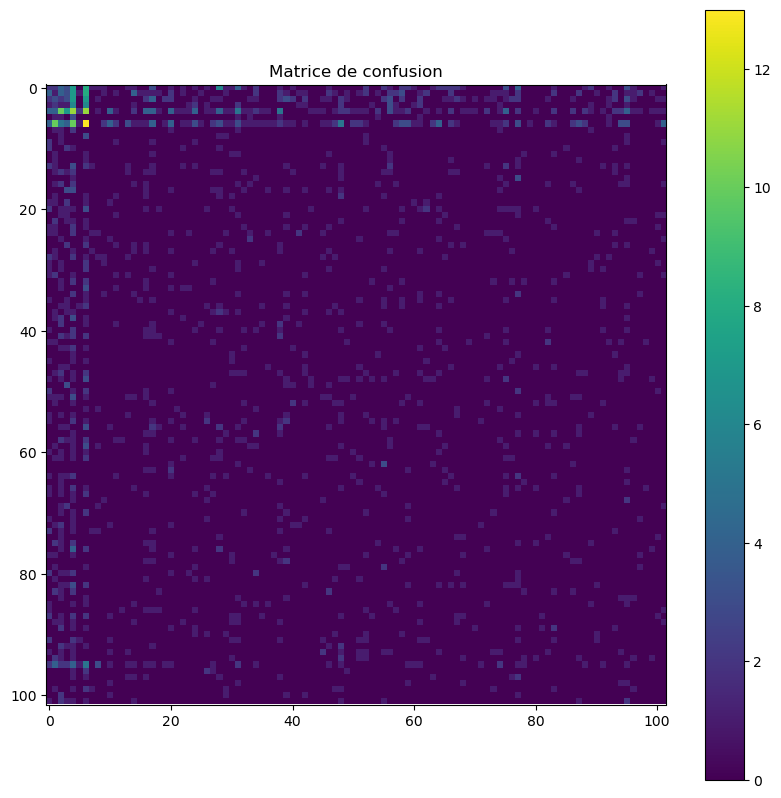

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Prédictions
y_true = val_gen.classes
y_pred = model_cnn.predict(val_gen).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm)
plt.title("Matrice de confusion")
plt.colorbar()
plt.show()


## 5 – Étude d'ablation

Nous testons plusieurs variantes :
- Dropout
- Batch Normalization
- Data augmentation
- Learning rate modifié
Dans cellule qui suit exemple avec dropout


In [20]:
model_drop = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])


c:\Users\thoma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Analyse qualitative des erreurs
Affichage des images mal classées.

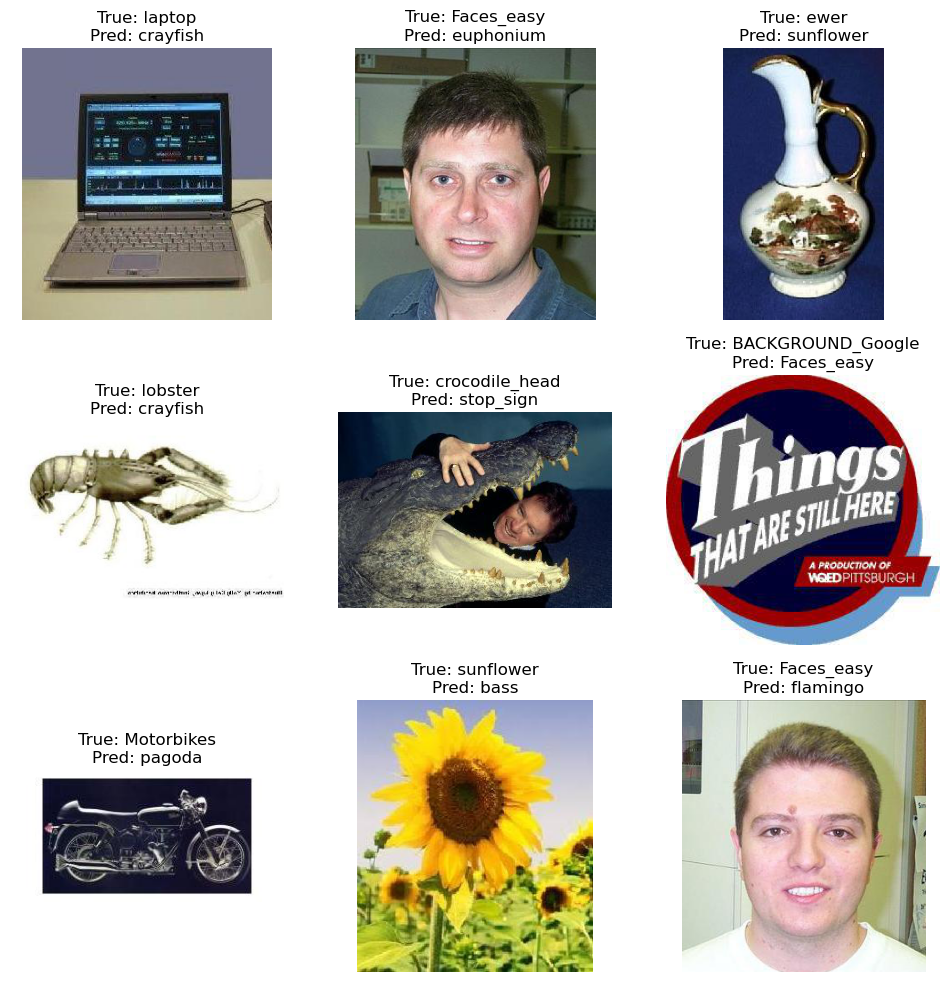

In [21]:
errors = np.where(y_pred != y_true)[0]
random_errors = np.random.choice(errors, 9)

plt.figure(figsize=(12,12))
for i, idx in enumerate(random_errors):
    img_path = val_gen.filepaths[idx]
    img = Image.open(img_path)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}")
    plt.axis("off")
plt.show()



## Conclusion :
